In [72]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = './data/phase/'
scan = os.scandir(path)
file_list = [entry.path for entry in scan if entry.is_file()]
file_list.sort()
file_list[:5], file_list[-5:], len(file_list)

(['./data/phase/000001.csv',
  './data/phase/000002.csv',
  './data/phase/000003.csv',
  './data/phase/000004.csv',
  './data/phase/000005.csv'],
 ['./data/phase/599886.csv',
  './data/phase/599890.csv',
  './data/phase/599909.csv',
  './data/phase/599930.csv',
  './data/phase/599958.csv'],
 16734)

In [3]:
number_list = [int(x.split('/')[-1].split('.')[0]) for x in file_list]
bins = 600
hist, bins_edges = np.histogram(number_list, bins=bins)

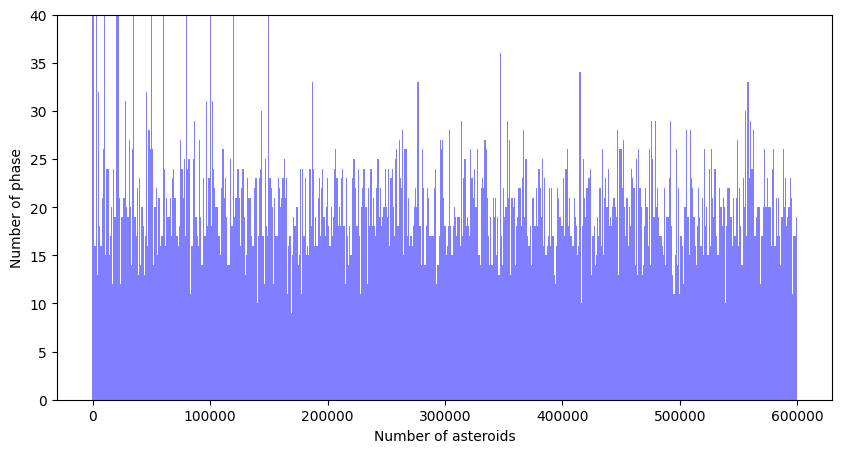

In [4]:
plt.figure(figsize=(10, 5))
w = bins_edges[1] - bins_edges[0]
plt.bar(bins_edges[:-1], hist, width=w, color='b', alpha=0.5)
plt.xlabel('Number of asteroids')
plt.ylabel('Number of phase')
plt.ylim(0, 40)
plt.show()

In [68]:
new_index_list = []
max_n = 25
for i in range(bins_edges.size - 1):
    cond = (number_list > bins_edges[i]) & (number_list <= bins_edges[i + 1])
    cur_numbers = np.array(number_list)[cond]
    if cur_numbers.size <= max_n:
        cur_choisen_list = np.random.choice(cur_numbers, cur_numbers.size, replace=False)
        # cur_choisen_list = random.sample(list(cur_numbers), cur_numbers.size)
        new_index_list.extend(cur_choisen_list)
    else:
        # cur_choisen_list = random.sample(list(cur_numbers), max_n)
        cur_choisen_list = np.random.choice(cur_numbers, max_n, replace=False)
        new_index_list.extend(cur_choisen_list)
    # break
new_index_list.sort()
np.random.shuffle(new_index_list)
print(len(new_index_list), len(set(new_index_list)))
sr = pd.DataFrame(new_index_list, columns=['index'])
sr.to_csv('./data/choisen.csv', index=False)


11797 11797


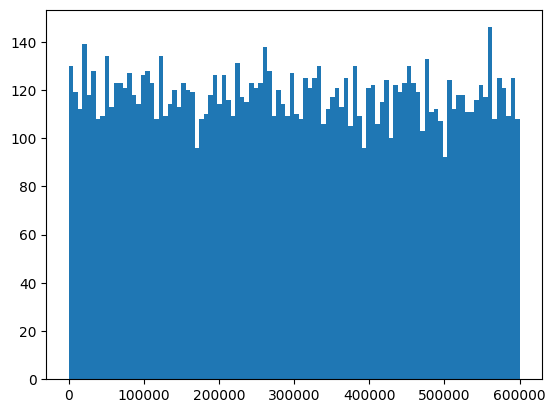

In [69]:
# new_index_list.sort()
plt.hist(new_index_list, bins=100)
plt.show()

In [84]:
columns_in = ['number', 'epoch', 'band', 'mag', 'RA_x', 'DEC_x', 'Date', 'Dobs', 'Dhelio', 'Phase',
            'mag_corr', 'RA_y', 'DEC_y', 'VMag']
columns_out = ['Name', 'jd_obs', 'filter', 'mag', 'ra_obs', 'dec_obs', 'Date', 'Dobs', 'Dhelio', 'Phase', 
            'reduced_mag', 'ra', 'dec', 'mag_in_V']
columns_out_final = ['name', 'Unnamed:0', 'jd_obs', 'filter', 'mag', 'ra_obs', 'dec_obs', 'Name', 'Date', 'Dobs', 'Dhelio', 'Phase', 
           'Processed', 'reduced_mag', 'uncertainty', 'phase', 'ra', 'dec', 'mag_in_V']
d = {}
for i, column in enumerate(columns_in):
    d[column] = columns_out[i]

In [85]:
def chr2numb(x):
    val = str(x)[0]
    if val.isalpha():
        if (val > 'A') & (val <= 'Z'):
            return int(ord(val) - 55)*10000 + int(x[1:])
        else:
            return int(ord(val) - 61)*10000 + int(x[1:])
    else:
        return int(x)

In [95]:
df_sample = pd.DataFrame(columns=columns_in)
t0 = time.time()
l = 0
curr_file_number = 1
is_first = True
for i, filename in enumerate(new_index_list):
    df = pd.read_csv(f'{path}{filename:06d}.csv', 
                     usecols=columns_in
                     )
    l += df.__len__()
    df['mag_corr'] = df['mag'] - 5 * np.log10(df['Dhelio'] * df['Dobs'])
    df['name'] = df['number'].apply(chr2numb)
    df['phase'] = df['Phase'] / 180.0 * np.pi
    coords = SkyCoord(ra=df['RA_y'], dec=df['DEC_y'], 
                      unit=(u.hourangle, u.deg))
    df['RA_y'] = coords.ra.rad
    df['DEC_y'] = coords.dec.rad

    if is_first:
        df_sample = df
        is_first = False
    else:
        df_sample = pd.concat([df_sample, df])

    if i % 100 == 0:
        print(f'{i:>5d} {l:>8d} files, lines read', end=' for ')
        print(f'{time.time() - t0:.2f} s', end=' size: ')
        print(f'{df_sample.memory_usage(index=True, deep=True).sum()/1024**2:.1f} MB')
        t0 = time.time()
    if l > 1_000_000:
        l = 0
        df_sample = df_sample.rename(columns=d)
        df_sample['Unnamed:0'] = df_sample.index
        df_sample['Processed'] = True
        df_sample['uncertainty'] = 0.1
        df_sample['Name'] = df_sample['Name'].astype(str)
        df_sample[columns_out_final]
        df_sample[columns_out_final].to_parquet(f'./data/sso_{curr_file_number:05d}.parquet', 
                                        engine='pyarrow',
                                        index=False)
        print(f'File sso_{curr_file_number:05d} saved')
        df_sample = pd.DataFrame(columns=columns_in)
        is_first = True
        curr_file_number += 1

df_sample = df_sample.rename(columns=d)
df_sample['Unnamed:0'] = df_sample.index
df_sample['Processed'] = True
df_sample['uncertainty'] = 0.1
df_sample['Name'] = df_sample['Name'].astype(str)
df_sample[columns_out_final]
df_sample[columns_out_final].to_parquet(f'./data/sso_{curr_file_number:05d}.parquet', 
                                engine='pyarrow',
                                index=False)
print(f'File sso_{curr_file_number:05d} saved')

    0      278 files, lines read for 0.08 s size: 0.1 MB
  100    56915 files, lines read for 15.85 s size: 12.5 MB
  200   116052 files, lines read for 16.83 s size: 25.2 MB
  300   180498 files, lines read for 18.58 s size: 38.9 MB
  400   253501 files, lines read for 20.91 s size: 54.5 MB
  500   297026 files, lines read for 13.11 s size: 64.1 MB
  600   359580 files, lines read for 18.59 s size: 77.5 MB
  700   406695 files, lines read for 14.64 s size: 87.9 MB
  800   466441 files, lines read for 18.43 s size: 100.7 MB
  900   526679 files, lines read for 18.58 s size: 113.7 MB
 1000   588525 files, lines read for 19.21 s size: 127.0 MB
 1100   651010 files, lines read for 19.66 s size: 140.5 MB
 1200   699583 files, lines read for 16.46 s size: 151.2 MB
 1300   761105 files, lines read for 20.11 s size: 164.5 MB
 1400   813498 files, lines read for 17.52 s size: 176.0 MB
 1500   872943 files, lines read for 19.69 s size: 188.9 MB
 1600   935985 files, lines read for 20.81 s size:

In [93]:
df_sample[columns_out_final]

name  Unnamed:0        jd_obs filter    mag      ra_obs    dec_obs  \
0    262381          0  2.452645e+06      0  19.10  109.440833  28.488639   
1    262381          1  2.452645e+06      0  19.40  109.436542  28.490000   
2    262381          2  2.452645e+06      0  19.60  109.432250  28.491611   
3    262381          3  2.452645e+06      0  19.30  109.428333  28.493028   
4    262381          4  2.452649e+06      0  19.40  108.404750  28.839139   
..      ...        ...           ...    ...    ...         ...        ...   
822  134754        822  2.460016e+06      R  19.40  124.658458  24.850361   
823  134754        823  2.460049e+06      G  20.13  126.890296  24.232150   
824  134754        824  2.460049e+06      G  20.15  126.891225  24.231931   
825  134754        825  2.460049e+06      G  19.96  126.892246  24.231619   
826  134754        826  2.460049e+06      G  19.96  126.893504  24.231289   

      Name          Date      Dobs    Dhelio      Phase  Processed  \
0    Q2381  2.452645e+06  1.623851  2.602955   2.536005       True   
1    Q2381  2.452645e+06  1.623866  2.602978   2.533433       True   
2    Q2381  2.452645e+06  1.623881  2.603001   2.530906       True   
3    Q2381  2.452645e+06  1.623895  2.603024   2.528424       True   
4    Q2381  2.452649e+06  1.629825  2.608820   2.575742       True   
..     ...           ...       ...       ...        ...        ...   
822  D4754  2.460016e+06  1.921476  2.667325  16.671220       True   
823  D4754  2.460049e+06  2.274573  2.635310  22.031318       True   
824  D4754  2.460049e+06  2.274644  2.635304  22.031743       True   
825  D4754  2.460049e+06  2.274711  2.635299  22.032143       True   
826  D4754  2.460049e+06  2.274802  2.635291  22.032686       True   

     reduced_mag  uncertainty     phase        ra       dec   mag_in_V  
0      15.969935          0.1  0.044262  1.910099  0.497219  19.915620  
1      16.269896          0.1  0.044217  1.910028  0.497244  19.915484  
2      16.469857          0.1  0.044173  1.909957  0.497269  19.915352  
3      16.169819          0.1  0.044129  1.909886  0.497294  19.915222  
4      16.257074          0.1  0.044955  1.892013  0.503339  19.931165  
..           ...          ...       ...       ...       ...        ...  
822    15.851446          0.1  0.290968  2.175703  0.433725  19.829349  
823    16.241342          0.1  0.384519  2.214660  0.422935  20.341987  
824    16.261279          0.1  0.384526  2.214678  0.422930  20.342063  
825    16.071220          0.1  0.384533  2.214694  0.422925  20.342135  
826    16.071139          0.1  0.384543  2.214717  0.422919  20.342232  

[10316 rows x 19 columns]

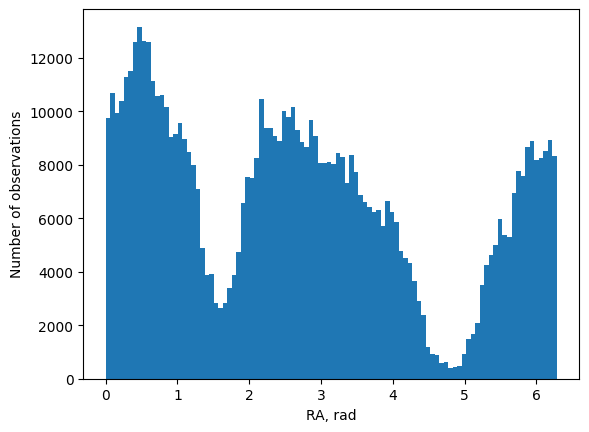

In [27]:
plt.hist(df_sample['RA_y'], bins=100)
plt.xlabel('RA, rad')
plt.ylabel('Number of observations')
plt.show()

In [28]:
df_sample = df_sample.rename(columns=d)
df_sample['Unnamed:0'] = df_sample.index
df_sample['Processed'] = True
df_sample['uncertainty'] = 0.1
df_sample[columns_out_final]

name  Unnamed:0        jd_obs filter    mag      ra_obs    dec_obs  \
0       65          0  2.413019e+06      V  10.50  289.361958 -18.172556   
1       65          1  2.413022e+06      V  10.80  288.794625 -18.278917   
2       65          2  2.414715e+06      V  10.90  180.274750   1.201667   
3       65          3  2.414729e+06      V  10.30  177.990250   2.421417   
4       65          4  2.414731e+06      V  10.60  177.665958   2.591167   
..     ...        ...           ...    ...    ...         ...        ...   
112  x9285        112  2.459971e+06      G  20.22  141.865142  -3.611281   
113  x9285        113  2.460018e+06      G  20.15  132.946379  -1.530531   
114  x9285        114  2.460018e+06      G  20.29  132.945929  -1.530050   
115  x9285        115  2.460018e+06      G  20.65  132.945496  -1.529611   
116  x9285        116  2.460018e+06      G  20.36  132.945000  -1.529061   

       Name          Date      Dobs    Dhelio      Phase  Processed  \
0        65  2.413019e+06  2.106652  3.121490   1.339023       True   
1        65  2.413022e+06  2.109818  3.122833   1.868997       True   
2        65  2.414715e+06  2.407796  3.366797   5.055976       True   
3        65  2.414729e+06  2.358551  3.353421   0.462076       True   
4        65  2.414731e+06  2.356477  3.351617   0.650474       True   
..      ...           ...       ...       ...        ...        ...   
112  599285  2.459971e+06  1.327086  2.252896  11.120390       True   
113  599285  2.460018e+06  1.416179  2.263729  16.676331       True   
114  599285  2.460018e+06  1.416219  2.263732  16.678161       True   
115  599285  2.460018e+06  1.416258  2.263734  16.679990       True   
116  599285  2.460018e+06  1.416298  2.263736  16.681820       True   

     reduced_mag  uncertainty     phase        ra       dec   mag_in_V  
0       6.410227          0.1  0.023370  5.050311 -0.317157  11.144694  
1       6.706031          0.1  0.032620  5.040416 -0.319022  11.191738  
2       6.355817          0.1  0.088243  3.146374  0.020988  11.837607  
3       5.809334          0.1  0.008065  3.106517  0.042274  11.455608  
4       6.112412          0.1  0.011353  3.100842  0.045229  11.475246  
..           ...          ...       ...       ...       ...        ...  
112    17.841800          0.1  0.194087  2.476010 -0.063011  20.249482  
113    17.620287          0.1  0.291057  2.320341 -0.026696  20.600679  
114    17.760224          0.1  0.291089  2.320334 -0.026687  20.600804  
115    18.120161          0.1  0.291121  2.320328 -0.026679  20.600929  
116    17.830098          0.1  0.291153  2.320321 -0.026670  20.601054  

[682812 rows x 19 columns]

In [31]:
df_sample['name'] = df_sample['name'].astype(str)
df_sample[columns_out_final].to_parquet('/tmp/example.parquet', 
                                        engine='pyarrow',
                                        index=False)

**Proposal to correct data file format**

1. remove the **Data** column or convert the jd data to the *isot* format: **2023-02-24T12:00:00.000**<br>
2. rename **Unnamed:0** column to **index**<br>
3. remove **Name** column or convert it to **designation**<br>
*comment:* we have two columns **name** and **Name** <br>
I suggest to use follow coulmns to identification of asteroid: <br>
**number** (Int or nan)<br>
**name** (String or nan)<br>
**designation** the provisional designation name, for example: **2000 LW28**<br>
4. columns **phase, ra, dec** to **phase_rad, ra_rad, dec_rad**<br>
5. Add the **observatory** column<br>
